# UC02 - Medical Text Classification - Private Datasets - (Secure Training)

**Author:**
- Carlos Salgado - Github: [@socd06](https://github.com/socd06)

## Step 1 - Problem Statement

As in the previous tutorial, we suppose you run a deep learning company that provides NLP expertise with two clients: Bob <sup>MD</sup> and Alice <sup>MD</sup>. For this tutorial, we assume each of them are physicians running their respective medical practices and have a database of private medical transcriptions.

Bob and Alice have heard of the great services you provide and asked you to create a text classifier to help them automatically assign a medical specialty to each patient transcription.

Using data from both Bob's and Alice's datasets, you would be able to create a bigger dataset that you can use to train a better classifer. Because the nature of the data, you would normally not be allowed to do this because the data is private.

You can't reveal their data to any third party and you cannot move Bob's data to your company's machines. Same for Alice's. Each dataset is contrained to live on its owner's machine, and they cannot be mixed together to create a bigger dataset.

Text datasets cannot be consumed directly for training a neural training. You need to create numerical representations of each text review before PySyft can consume it. Text needs to be tokenized first, preprocessed and vector embedding should be used instead of plaintext. But how to do such preprocessing if you are not allowed to have access to plaintext data? 

As seen before, **SyferText** can help you define preprocessing components that you can send over a network to Bob's and Alice's machine to perform preprocessing remotely, blindly and in a completely secure fashion. SyferText components do all the work from processing plaintext to obtaining its vector representation and encrypting it to hand it over to PySyft models for training. All without you accessing the data, and without the data quitting their owners machine.

**Let's summarize:**

1. You need to create a bigger dataset out of Bob's and Alice's smaller datasets. *(PySyft has the arsenal for that)*

2. You need to prepare and preprocess the text data on Bob's and Alice's machines without revealing it, without moving any datasets to your machine, and without the need to work directly on Bob's or Alice's machines. *(SyferText to the rescue)*

For this tutorial, we are going to work with a medical transcriptions sample dataset. Which is a simulated dataset and a public dataset. For this tutorial, we are going to perform exploratory analysis and feature engineering to prepare the data to analysis. Then, we are going to break the data into two parts, send each part to a differet PySyft worker and then train the model.

## Step 2 - Importing libraries

Let's first install and import some libraries that we are going to be used all along this tutorial:

In [1]:
!pip install -r requirements.txt
# requirements should include syfertext, sklearn, numpy, matplotlib, seaborn
# NOTE: I was missing sklearn, matplotlib, seaborn in my venv

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [4]:
# SyferText imports
import syfertext
from syfertext.pipeline import SimpleTagger

# Import useful utility functions for this tutorial
from utils import download_dataset

# PySyft and PyTorch import
import syft as sy
from syft.generic.string import String
import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim

# Useful imports
import numpy as np
from tqdm import tqdm
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sb
import os
from pprint import pprint

sb.set()

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/home/carlos/anaconda3/envs/pysyft/lib/python3.7/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.2.so'


## Step 3 - Download the Dataset

<div>
    <p style='color:red;'> (IGNORE THIS STEP IF YOU HAVE ALREADY DONE IT) </p>
</div>

The dataset will be downloaded in a folder called `./mtsamples` in the same directory as the current notebook's. Four files are going to be downloaded:

- `mtsamples.csv`: This is the dataset file containing almost 5K sample medical transcriptions. It is a csv file composed of five columns: `description`,`medical_specialty`,`sample_name`,`transcription`, and `keywords`. The `transcription` column holds the sample text, and the `medical_specialty` contains the labels we will use to train the classifier. 

Please run the below cell in order to download the dataset.

In [2]:
# The URL template to all dataset files
url_template = 'https://raw.githubusercontent.com/socd06/medical_transcriptions/master/%s'

# File names to be downloaded from the using the URL template above
files = ['mtsamples.csv']

# Construct the list of urls
urls = [url_template % file for file in files]

# The dataset name and its root folder
dataset_name = 'mtsamples'
root_path = './mtsamples'

# Create the dataset folder if it is not already there
if not os.path.exists('./mtsamples'):
    os.mkdir('./mtsamples')

# Start downloading
download_dataset(dataset_name = dataset_name, 
                 urls = urls, 
                 root_path = root_path
                )
print("Succesfully downloaded:",files)

Preparing to download dataset: `mtsamples` ...


mtsamples: 17.0MB [00:04, 3.52MB/s]                            


## Step 4 - Data Exploration

In [3]:
# Import tools for exploratory analysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
# Reading dataset
df_full = pd.read_csv('mtsamples/mtsamples.csv', delimiter=',')
df_full.dataframeName = 'mtsamples.csv'

In [5]:
# Taking a quick look at what the data looks like
df_full.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [6]:
# We should drop any records with empty transcription text, since its  the main source of text we will work with
#df = df['transcription'].dropna()

df = df_full.dropna(subset=['transcription'])

In [7]:
df

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...,...,...,...,...
4994,4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e...",NaN
4995,4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN
4997,4997,Mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"CHIEF COMPLAINT: , This 5-year-old male presen...",NaN


Now we can start our exploration

In [8]:
# Examine what the specialties are
df['medical_specialty'].unique()

array([' Allergy / Immunology', ' Bariatrics',
       ' Cardiovascular / Pulmonary', ' Neurology', ' Dentistry',
       ' Urology', ' General Medicine', ' Surgery', ' Speech - Language',
       ' SOAP / Chart / Progress Notes', ' Sleep Medicine',
       ' Rheumatology', ' Radiology', ' Psychiatry / Psychology',
       ' Podiatry', ' Physical Medicine - Rehab',
       ' Pediatrics - Neonatal', ' Pain Management', ' Orthopedic',
       ' Ophthalmology', ' Office Notes', ' Obstetrics / Gynecology',
       ' Neurosurgery', ' Nephrology', ' Letters',
       ' Lab Medicine - Pathology', ' IME-QME-Work Comp etc.',
       ' Hospice - Palliative Care', ' Hematology - Oncology',
       ' Gastroenterology', ' ENT - Otolaryngology', ' Endocrinology',
       ' Emergency Room Reports', ' Discharge Summary',
       ' Diets and Nutritions', ' Dermatology',
       ' Cosmetic / Plastic Surgery', ' Consult - History and Phy.',
       ' Chiropractic', ' Autopsy'], dtype=object)

In [9]:
# And how many different ones
len(df['medical_specialty'].unique())

40

In [10]:
df['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

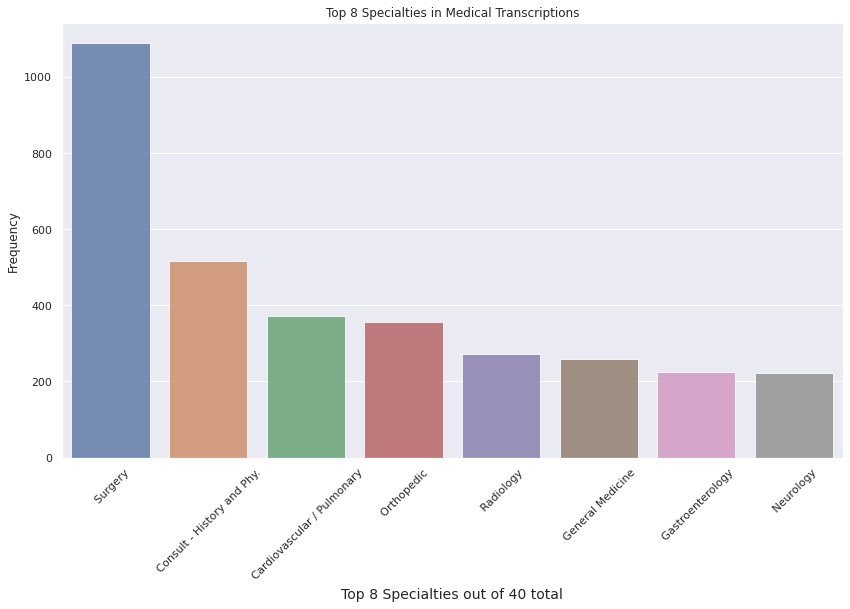

In [11]:
# Display the top 10 specialties most frequently repeated in the text
# The top 10 specialties will be most likely to be predicted since the model will be trained mainly on them
fig, ax = plt.subplots(figsize = (14,8)) # set size of figure
specialty = df['medical_specialty'].value_counts()
specialty = specialty[:8,]
g = sb.barplot(specialty.index, specialty.values, alpha=0.8)

plt.title("Top 8 Specialties in Medical Transcriptions")
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Top 8 Specialties out of 40 total", fontsize=14)

g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.show()

We will only use the specialties with the most data (over 200 samples). Now we know we can work with the first 8 specialties and the text to build a classifier that can should recognize 8 different classes.

In [12]:
# Choosing features
features = ['medical_specialty', 'transcription']

# Data is called X by convention
X = df[features]

In [13]:
# Confirming our new dataset only has the two columns chosen
X.head()

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


In [14]:
# Using the specialty variable from earlier to filter our data
top8 = specialty.index.values
top8

array([' Surgery', ' Consult - History and Phy.',
       ' Cardiovascular / Pulmonary', ' Orthopedic', ' Radiology',
       ' General Medicine', ' Gastroenterology', ' Neurology'],
      dtype=object)

In [15]:
# 
X_filtered = X.loc[X['medical_specialty'].isin(top8)]
X_filtered

,medical_specialty,transcription
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
7,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
9,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
11,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."
...,...,...
4972,Cardiovascular / Pulmonary,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden..."
4973,Cardiovascular / Pulmonary,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES..."
4974,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , The patient is a..."
4975,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-..."


If we pay attention to the resulting dataframe, we can notice some indexes have gone missing because we filtered out some datapoints. We need to reset the indexes now.

In [16]:
X_filtered.head()

,medical_specialty,transcription
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
7,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
9,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
11,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


In [17]:
# drop=True assures we don't keep the old index column in our dataframe
X_filtered = X_filtered.reset_index(drop=True)

In [18]:
X_filtered.head()

,medical_specialty,transcription
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


Now our indexes are fixed and we can move onto the next section.

# Step 5 - Label integer encoding

Because we will use `medical_specialty` as our classes, we need to encode them as numbers from 0 to 7. We will use sklearn's label encoder for that.

In [19]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['medical_specialty']
encoder = LabelEncoder()

# Apply the label encoder to each column
encoded = X_filtered[cat_features].apply(encoder.fit_transform)
encoded.head(30)

,medical_specialty
0,0
1,0
2,0
3,0
4,0
5,4
6,0
7,3
8,7
9,7


In [20]:
# Encoding the original feature as medical_specialty_text
# and the label we'll use for the model as medical_specialty_label
X_encoded = X_filtered.join(encoded, lsuffix='_text', rsuffix='_label')

In [21]:
# Examine what the specialties are
encoded_text = X_encoded['medical_specialty_text'].unique()
encoded_text.tolist()

[' Cardiovascular / Pulmonary',
 ' Neurology',
 ' General Medicine',
 ' Surgery',
 ' Radiology',
 ' Orthopedic',
 ' Gastroenterology',
 ' Consult - History and Phy.']

In [22]:
encoded_labels = X_encoded['medical_specialty_label'].unique()
encoded_labels.tolist()

[0, 4, 3, 7, 6, 5, 2, 1]

In [23]:
# Converting the lists to a dictionary to use as our mappings guide
keys = encoded_labels
values = encoded_text
encoded_mappings = dict(zip(keys, values))

In [24]:
# Now we can look at what our mappings became
encoded_mappings

{0: ' Cardiovascular / Pulmonary',
 4: ' Neurology',
 3: ' General Medicine',
 7: ' Surgery',
 6: ' Radiology',
 5: ' Orthopedic',
 2: ' Gastroenterology',
 1: ' Consult - History and Phy.'}

In [25]:
# and extract and example
encoded_mappings[0]

' Cardiovascular / Pulmonary'

In [26]:
# Doing a sanity check 
X_encoded.head(30)

,medical_specialty_text,transcription,medical_specialty_label
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...",0
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,0
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",0
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....",0
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...",0
5,Neurology,"CC:, Confusion and slurred speech.,HX , (prima...",4
6,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSES,Airway obstruction seco...",0
7,General Medicine,"HISTORY OF PRESENT ILLNESS:, The patient is a...",3
8,Surgery,"PREOPERATIVE DIAGNOSES:,1. Hallux rigidus, le...",7
9,Surgery,"PREOPERATIVE DIAGNOSIS: , Secondary capsular m...",7


Now our data is ready to be used and we will save this new dataframe as a comma sepparated values file (*.csv)

In [27]:
X_encoded.to_csv('mtsamples/mtdata.csv', index = False)

## Step 5 - Preparing the work environment

As in the previous tutorial, we will simulate a work environment with three main actors, a company (me) and two clients owning two private datasets (Bob and Alice) but also a crypto provider which will provide the primitives for Secure Multi-Party Encryption (SMPC).

In [28]:
# Create a torch hook for PySyft
hook = sy.TorchHook(torch)

# Create some PySyft workers
me = hook.local_worker # This is the worker representing the deep learning company
bob = sy.VirtualWorker(hook, id = 'bob') # Bob owns the first dataset
alice = sy.VirtualWorker(hook, id = 'alice') # Alice owns the second dataset

crypto_provider = sy.VirtualWorker(hook, id = 'crypto_provider') # provides encryption primitive for SMPC

# Create a summary writer for logging performance with Tensorboard
writer = SummaryWriter()

## Step 5 - Simulating Private Datasets

As in the previous tutorial, we will simulate two private datasets owned by two clients (Bob and Alice) but we will skip loading since we already loaded during out exploratory analysis:

1. Load the whole dataset in `mtsamples.csv` locally (the `me` worker). This dataset will be loaded as a list of dictionaries that has the following format: `[ {'transcription': <transcription text>, 'label': <0 - 7>}, {...}, {...}]`


2. Split the dataset into two parts, one for Bob and the other for Alice. Each part will be also split into a training set and a validation set. This will create four lists: `train_bob`, `valid_bob`, `train_alice`, `valid_alice`. Each list has the same format mentioned above.


3. Each element in the four lists will be sent to the corresponding worker. This will change the content of the lists as depicted in **Figure(1)**. Each list willl hold PySyft pointers to the texts and labels instead of the objects themselves.

<div>
<br>
<img alt = 'imdb review remote datasets' src ='./art/imdb_review_remote.png' style='width:700px'>
<div>
<div style='width:600px;margin:30px auto 10px auto;text-align:center;'>
<strong> Figure(1): </strong> The reviews and their labels are remotely located on Bob's and Alice's remote machines, only pointers to them are kept by the local worker (the company's machine).
</div>
</div>
<br>
</div>

Let's load the dataset locally:

In [29]:
# Set the path to the dataset file
dataset_path = './mtsamples/mtdata.csv'

# store the dataset as a list of dictionaries
# each dictionary has two keys, 'transcription' and 'label'
# the 'transcription' element is a PySyft String
# the 'label' element is an integer from 0 to 7, being each number a different medical specialty'
dataset_local = []

In [30]:
with open(dataset_path, 'r') as dataset_file:
    
    # Create a csv reader object
    reader = csv.DictReader(dataset_file)
    
    for elem in reader:
        
        # Create one entry
        example = dict(transcription = String(elem['transcription']),                       
                       label = int(elem['medical_specialty_label'])
                      )
        
        # add to the local dataset
        dataset_local.append(example)

Here is how an element in the list looks like:

In [31]:
example = dataset_local[100]
pprint(example)

{'label': 7,
 'transcription': 'PREOPERATIVE DIAGNOSES:,  Hypertrophy of tonsils and adenoids, and also foreign body of right ear.,POSTOPERATIVE DIAGNOSES:,  Hypertrophy of tonsils and adenoids, and also foreign body of right ear.,OPERATIONS:,  Tonsillectomy, adenoidectomy, and removal of foreign body (rock) from right ear.,ANESTHESIA:,  General.,HISTORY: , The patient is 5-1/2 years old.  She is here this morning with her Mom.  She has very large tonsils and she snores at night and gets up frequently at night and does not sleep well.  At the office we saw the tonsils were very big.  There was a rock in the right ear and it was very deep in the canal, near the drum.  We will remove the foreign body under the same anesthetic.,PROCEDURE:,:  Natalie was placed under general anesthetic by the orotracheal route of administration, under Dr. XYZ and Ms. B.  I looked into the left ear under the microscope, took out a little wax and observed a normal eardrum.  On the right side, I took out some

In [32]:
# We can double check that the label was set properly
encoded_mappings[7]

' Surgery'

Let's check out the data types:

In [33]:
print(type(example['transcription']))
print(type(example['label']))

<class 'syft.generic.string.String'>
<class 'int'>


This review text is a PySyft `String` object. The label is an integer.

Let's split the dataset into two equal parts and send each part to a different worker simulating two remote datasets as I mentioned above:

In [34]:
# Create two datasets, one for Bob and another one for Alice
dataset_bob, dataset_alice = train_test_split(dataset_local, train_size = 0.5)

# Now create a validation set for Bob and another one for Alice
train_bob, val_bob = train_test_split(dataset_bob, train_size = 0.7)
train_alice, val_alice = train_test_split(dataset_alice, train_size = 0.7)

Making the dataset remote:

### One-hot label encoding from  0-7 to 1x3 tensor

In [35]:
batch_size = 8
nb_digits = 3

#Dummy input that HAS to be 2D for the scatter (you can use view(-1,1) if needed)
dummy = torch.LongTensor(batch_size,1).random_() % nb_digits

print(dummy)

tensor([[0],
        [2],
        [2],
        [1],
        [0],
        [0],
        [0],
        [0]])


In [36]:
#One hot encoding buffer that you create out of the loop and just keep reusing
y_onehot = torch.FloatTensor(batch_size, nb_digits)

#In your for loop
y_onehot.zero_()
y_onehot.scatter_(1, dummy, 1)

print(y_onehot)

tensor([[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])


In [37]:
# Sanity checking one example
print(y_onehot[example['label']])

tensor([1., 0., 0.])


In [38]:
# A function that sends the content of each split to a remote worker
def make_remote_dataset(dataset, worker):

    # Got through each example in the dataset
    for example in dataset:
        
        # Send each review text
        example['transcription'] = example['transcription'].send(worker)

        # Send each label as a one-hot-encoded vector
        one_hot_label = y_onehot[example['label']]
        
        # Send the review label
        example['label'] = one_hot_label.send(worker)

Note that the above function transforms the label to a one-hot-encoded format before sending it to a remote worker. So if the sentiment is negative, the corresponding tensor will hold `[1,0]`, and if it is positive, the label will be `[0,1]`. I actually choose this representation over a simple `1` or `0` due to some limitations in PySyft at the moment of writing this blogpost. This limitation is being worked on, and will be solved very soon.

I can finally create the remote datasets:

In [39]:
# Bob's remote dataset
make_remote_dataset(train_bob, bob)
make_remote_dataset(val_bob, bob)

# Alice's remote dataset
make_remote_dataset(train_alice, alice)
make_remote_dataset(val_alice, alice)

Let me show you what an element of Bob's dataset look like:

In [40]:
# Take an element from the dataset
example = train_bob[10]

print(type(example['transcription']))
print(example['label'])

<class 'syft.generic.pointers.string_pointer.StringPointer'>
(Wrapper)>[PointerTensor | me:75531136354 -> bob:32190639815]


Wow, the text type is now a PySyft `StringPointer` that points to the real `String` object  located in Bob's machine. The label type is a PySyft `PointerTensor`. Let's check out the location of the real text and label:

In [41]:
print(example['transcription'].location)
print(example['label'].location)

<VirtualWorker id:bob #objects:3308>
<VirtualWorker id:bob #objects:3308>


Well, you can see it for yourself, they are located in Bob's machine. This confirms **Figure(1)**.

The datasets are now ready, and so is the work environment. Let's start the fun with SyferText :) 

## Step 6 - Create a `SyferText` Language object

The Language object in SyferText is the master object. It orchestrates all the work done by SyferText. Let's create one:

In [42]:
# Create a Language object with SyferText
nlp = syfertext.load('en_core_web_lg', owner = me)

Whenever you create a Language object as we did above, a pipeline will be created. At initialization, a pipeline only contains a tokenizer. You can see this for yourself using the `pipeline_template` property:

In [43]:
nlp.pipeline_template

[{'remote': True, 'name': 'tokenizer'}]

Notice that the tokenizer entry has a propery called `remote` set to `True`. This means we allowed the tokenizer to be sent to a remote worker for the string to be tokenized there.

We can add more components to the pipeline by using the `add_pipe` method of the Language class. One component we can add is a `SimpleTagger` object. This is a SyferText object that we can use to set custom attributes to individual tokens. In this tutorial, we will create two taggers: One that tags tokens that are Stop Words and another one that tags each token with their respective class.

By tagging we mean setting a custom attribute to a token and assigning it a given value (e.g. An attribute called `is_stop` with `True` and `False` values when evaluating Stop Words. 

You can refer to **Figure(2)** to see how a pipeline is distributed on multiple workers on the dataset to preprocess is remote.

### Download Stop Words

This database does not come with a list of Stop Words. For this case, we will download a Stop Words file from a [kavgan's](https://github.com/kavgan) [clinical-concepts](https://github.com/kavgan/clinical-concepts) repository. 

In [49]:
# The URL template to all dataset files
url_template = 'https://raw.githubusercontent.com/kavgan/clinical-concepts/master/%s'

# File names to be downloaded from the using the URL template above
files = ['clinical-stopwords.txt']

# Construct the list of urls
urls = [url_template % file for file in files]

# The dataset name and its root folder
dataset_name = 'mtsamples'
root_path = './mtsamples'

# Create the dataset folder if it is not already there
if not os.path.exists('./mtsamples'):
    os.mkdir('./mtsamples')

# Start downloading
download_dataset(dataset_name = dataset_name, 
                 urls = urls, 
                 root_path = root_path
                )
print("Succesfully downloaded:",files)

mtsamples:   0%|          | 0.00/6.58k [00:00<?, ?B/s]

Preparing to download dataset: `mtsamples` ...


mtsamples: 7.17kB [00:00, 58.3kB/s]                            

Succesfully downloaded: ['clinical-stopwords.txt']


### Create a  tagger for stop words

We will start by creating the stop-word tagger. Let's first load the stop word file into a list of words:

In [50]:
# Load the list of stop words
with open('./mtsamples/clinical-stopwords.txt', 'r') as f:
    stop_words = set(f.read().splitlines())

Now we create the tagger which is an object of the `SimpleTagger` class:

In [51]:
# Create a simple tagger object to tag stop words
stop_tagger = SimpleTagger(attribute = 'is_stop',
                           lookups = stop_words,
                           tag = True,
                           default_tag = False,
                           case_sensitive = False
                          )

Notice that I pass the list of words as the `lookups` arguments. 

Every token in the `Doc` object will be given a custom attribute called `is_stop`. Every time a stop word is found, this attribute will be given the value `True` specified by the `tag` argument of the `SimpleTagger` class initialiser, otherwise, the `default_tag` will be used, i.e., `False`.

### Download Vocabulary
This database does not come with a vocabulary file but we can download one that was created specifically for this experiment.

In [5]:
# The URL template to all dataset files
url_template = 'https://raw.githubusercontent.com/socd06/snmi_vocab/master/%s'

# File names to be downloaded from the using the URL template above
files = ['vocab.txt']

# Construct the list of urls
urls = [url_template % file for file in files]

# The dataset name and its root folder
dataset_name = 'mtsamples'
root_path = './mtsamples'

# Create the dataset folder if it is not already there
if not os.path.exists('./mtsamples'):
    os.mkdir('./mtsamples')

# Start downloading
download_dataset(dataset_name = dataset_name, 
                 urls = urls, 
                 root_path = root_path
                )
print("Succesfully downloaded:",files)

Preparing to download dataset: `mtsamples` ...


mtsamples: 702kB [00:01, 373kB/s]                             

Succesfully downloaded: ['vocab.txt']


# TODO List
## - ignore polarity file
## - map class to word

In [6]:
# Load the polarity info
with open('./mtsamples/vocab.txt', 'r') as f:
    mtsamples_words = f.read().splitlines()

### Create a tagger for most polar words

In the same way we created a tagger for stop words. We are now going to create another tagger for polar words, i.e., words that are more biased toward a positive or a negative sentiment. Let's load the corresponding files `imdb_vocab.txt` and `imdb_polarity.txt`:

In [ ]:
with open('./imdb/imdb_polarity.txt', 'r') as f:
    polarity = [float(line) for line in f.read().splitlines()]

Let me show you the distribution of polarity values:

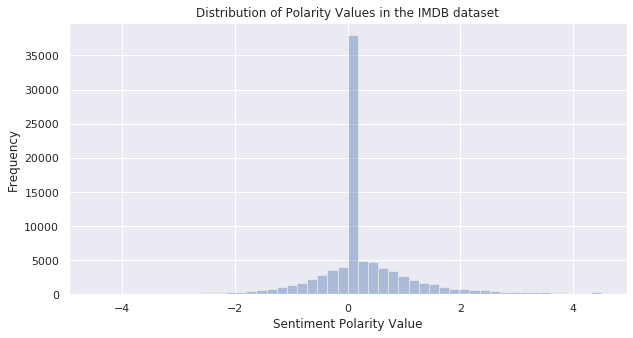

In [88]:
# Create the histogram of polarity values
fig, ax = plt.subplots(figsize = (10,5))
sb.distplot(polarity, kde = False, ax = ax)

ax.set_xlabel('Sentiment Polarity Value')
ax.set_ylabel('Frequency')
ax.set_title("Distribution of Polarity Values in the IMDB dataset");

We notice that the grand majority of words seem to be unbiased toward a specific sentiment. So let's create a tagger that tags only tokens that are most polar by setting a custom attribute we will call `is_polar` to `True` and `False` otherwise:

In [57]:
# Choose low/high polarity cutoff values
low_cutoff = -0.5
high_cutoff = 0.5

# Create a list of polar tokens
polar_tokens = [token for i, token in enumerate(imdb_words) 
                if polarity[i] > high_cutoff or
                polarity[i] < low_cutoff]

Using the list of polar word above, we can now create the tagger:

In [58]:
polarity_tagger = SimpleTagger(attribute = 'is_polar',
                               lookups = polar_tokens,
                               tag = True,
                               default_tag = False,
                               case_sensitive = False
                              )

### 0.3 Adding the taggers to the pipeline

We can add each tagger we created above by using the `add_pipe()` method of the `Language` class. However, in the following cell, I give you the possibility to decide for yourself which components you wish to add.

Here is what I recommend you do:

1. First run this tutorial without adding an tagger.

2. Restart the notebook and run the tutorial again with `use_stop_tagger = True`.

3. Restart the notebook and run the tutorial again with both `use_stop_tagger = True` and `use_polarity_tagger = True`.

I will actually show you the results of each such run at the end of this notebook.

In [59]:
use_stop_tagger = False
use_polarity_tagger = False

# Token with these custom tags
# will be excluded from creating
# the Doc vector
excluded_tokens = {}

Notice that in the above cell. I create a dictionary called `excluded_tokens`. It will be used later in this tutorial when we create embedding vectors for reviews. It enables us to execlude some tokens when we create a document embedding. Such exclusion will be based on the value of the custom attributes we set with the taggers.

Now let's add the stop word tagger to the pipeline (If `use_stop_tagger = True`). Notice that I set the argument `remote = True`. This tells the `Language` object that it is allowed to send the pipe component to the remote worker.

In [60]:
if use_stop_tagger:

    # Add the stop word to the pipeline
    nlp.add_pipe(name = 'stop tagger',
                 component = stop_tagger,
                 remote = True
                )

    # Tokens with 'is_stop' = True are
    # not going to be used when creating the 
    # Doc vector
    excluded_tokens['is_stop'] = {True}

Same for adding the polar word tagger:

In [61]:
if use_polarity_tagger:
    
    # Add the polarity tagger to the pipeline
    nlp.add_pipe(name = 'polarity tagger',
                 component = polarity_tagger,
                 remote = True
                )

    # Tokens with 'is_polar' = False are
    # not going to be used when creating the 
    # Doc vector
    excluded_tokens['is_polar'] = {False}

Let's check out what pipe components are included in the pipeline:

In [63]:
nlp.pipeline_template

[{'remote': True, 'name': 'tokenizer'},
 {'remote': True, 'name': 'stop tagger'}]

## 1. Create a Dataset class

Now that we have the remote datasets ready for use, and that SyferText's `Language` object set up with the appropriate pipeline, it's time to create data loaders that will take over the task of creating batches for training and validation.

We will be using regular PyTorch data loaders to accomplish that. 

Each batch will be composed of a mix of training examples coming from both Bob's and Alice's datasets. Actually, for the data loader, there is only one big dataset, it is completely ignorant of the fact that data is distributed over different workers. 

Each example in the batch contains an encrypted version of one review's embedding vector and its encrypted label. For this tutorial, I compute such a vector as an average of the review's individual token vectors taken from the `en_core_web_lg` language model. Of course, all tokens with custom tags indicated in `excluded_tokens` won't be taken into account in computing a review's vector.

If you look at **Figure(2)** you can see the big picture of how a single review text is remotely preprocessed by SyferText: 

1. First, the `Language` object `nlp` is used to preprocess one review on Bob's or Alice's machine.
2. The object `nlp` determines that the real review text is actually remote, so it sends a subpipeline containing the required pipeline components we defined to the corresponding worker.
3. The subpipeline is run and a `Doc` object is created on the remote worker containing the review's individual tokens appropriately tokenized and tagged.
4. On the local worker, a `DocPointer` object is created pointing to that `Doc` object.
5. By calling `get_encrypted_vector()` on the `DocPointer`, the call is forwarded to `Doc`, which, in turn, computes the `Doc` vector, encrypts it with SMPC using PySyft and returns it to the caller at the local worker.
6. The PyTorch dataloader takes this encrypted vector and appends it to the training or validation batch.

Notice that at no moment in the process, the plaintext data of the remote datasets are revealed to the local worker. *Privacy is preserved thanks to SyferText and PySyft!*

<div>
<br>
<img alt =  'SyferText pipeline' src ='./art/imdb_pipeline.png' style='width:700px;'>
<div>
<p style='width:600px;margin:30px auto 10px auto;text-align:center;'>
<strong> Figure(2): </strong> A pipeline on the local worker only contains pointers to subpipelines carrying out the actual preprocessing on remote workers.
</p>
</div>
<br>
</div>

All of the steps described above, except for *step 6.* are carried out in the `__getitem__()` method of the custom PyTorch `Dataset` object that I define below. Please take a few minutes to check it out below:

In [72]:
class DatasetIMDB(Dataset):
    
    def __init__(self, sets, share_workers, crypto_provider, nlp):
        """Initialize the Dataset object
        
        Args:
            sets (list): A list containing all training OR 
                all validation sets to be used.
            share_workers (list): T list of workers that will
                be used to hold the SMPC shares.
            crypto_provider (worker): A worker that will 
                provide SMPC primitives for encryption.
            nlp: This is SyferText's Language object containing
                the preprocessing pipeline.
        """
        self.sets = sets
        self.crypto_provider = crypto_provider
        self.workers = share_workers
    
        # Create a single dataset unifying all datasets
        # A property called `self.dataset` is created 
        # as a result of this call.
        self._create_dataset()
        
        # The language model
        self.nlp = nlp
        
    def __getitem__(self, index):
        """In this function, preprocessing with SyferText 
        of one review will be triggered. Encryption will also
        be performed and the encrypted vector will be obtained.
        The encrypted label will be computed too.
        
        Args:
            index (int): This is an integer received by the 
                PyTorch DataLoader. It specifies the index of
                the example to be fetched. This actually indexes
                one example in `self.dataset` which pools over
                example of all the remote datasets.
        """
        
        # get the example
        example = self.dataset[index]
        
        # Run the preprocessing pipeline on 
        # the review text and get a DocPointer object
        doc_ptr = self.nlp(example['review'])
        
        # Get the encrypted vector embedding for the document
        vector_enc = doc_ptr.get_encrypted_vector(bob, 
                                                  alice, 
                                                  crypto_provider = self.crypto_provider,
                                                  requires_grad = True,
                                                  excluded_tokens = excluded_tokens
                                                 )
        
        # The only reason I am expecting an AttributeError
        # here is this PySyft issue in version 0.2.4:
        # https://github.com/OpenMined/PySyft/issues/3261
        # Once the issue is fixed, there would be no need
        # for the try/except statement here.
        try:
            
            # Encrypte the target label
            label_enc = example['label'].fix_precision().share(bob, 
                                                               alice, 
                                                               crypto_provider = self.crypto_provider,
                                                               requires_grad = True
                                                              ).get()

        except AttributeError:
            
            label_enc = example['label'].share(bob, 
                                               alice, 
                                               crypto_provider = self.crypto_provider,
                                               requires_grad = True
                                              ).get()

        return vector_enc, label_enc

    
    def __len__(self):
        """Returns the combined size of all of the 
        remote training/validation sets.
        """
        
        # The size of the combined datasets
        return len(self.dataset)

    def _create_dataset(self):
        """Create a single list unifying examples from all remote datasets
        """
        
        # Initialize the dataset
        self.dataset = []
      
        # populate the dataset list
        for dataset in self.sets:
            for example in dataset:
                self.dataset.append(example)
                
    @staticmethod
    def collate_fn(batch):
        """The collat_fn method to be used by the
        PyTorch data loader.
        """
        
        # Unzip the batch
        vectors, targets = list(zip(*batch))

        # concatenate the vectors
        vectors = torch.stack(vectors)
        
        #concatenate the labels
        targets = torch.stack(targets)
        
        return vectors, targets

Let's now create two such `DatasetIMDB` objects, one for training and the other for validation:

In [73]:
# Instantiate a training Dataset object
trainset = DatasetIMDB(sets = [train_bob,
                               train_alice],
                       share_workers = [bob, alice],
                       crypto_provider = crypto_provider,
                       nlp = nlp
                      )

# Instantiate a validation Dataset object
valset = DatasetIMDB(sets = [val_bob,
                             val_alice],
                     share_workers = [bob, alice],
                     crypto_provider = crypto_provider,
                     nlp = nlp
                    )

## 2. Create a DataLoader

Let's now choose some hyper parameters for training and validation, and create the PyTorch data loaders:

In [74]:
# Set some hyper parameters
learning_rate = 0.001
batch_size = 32
epochs = 2

In [75]:
# Instantiate the DataLoader object for the training set
trainloader = DataLoader(trainset, shuffle = True,
                         batch_size = batch_size, num_workers = 0, 
                         collate_fn = trainset.collate_fn)


# Instantiate the DataLoader object for the validation set
valloader = DataLoader(valset, shuffle = True,
                       batch_size = batch_size, num_workers = 0, 
                       collate_fn = valset.collate_fn)



## 3. Create an Encrypted Classifier

The sentiment classifier I use here is a simple fully connected network with `300` input features which is the size of the embedding vectors computed by SyferText. The network has two outputs, one for negative sentiments and the other for positive ones.

In [22]:
class Classifier(torch.nn.Module):
    
    def __init__(self, in_features, out_features):
        super(Classifier, self).__init__()
        
        self.fc = torch.nn.Linear(in_features, out_features)
                
    def forward(self, x):
        
        logits = self.fc(x)
        
        probs = F.relu(logits)
        
        return probs, logits

I should now initialize and encrypt the classifier. Encryption here should of course use the same workers to hold the share and the same primitives used to encrypt the document vectors.

In [23]:
classifier = Classifier(in_features = 300, out_features = 2)

# Apply SMPC encryption
classifier = classifier.fix_precision().share(bob, alice, 
                                              crypto_provider = crypto_provider,
                                              requires_grad = True
                                              )
print(classifier)


Classifier(
  (fc): Linear(in_features=300, out_features=2, bias=True)
)


And finally I create an optimizer. Notice that the optimizer does not need to be encrypted, since it operates separately within each worker holding the classifier's and embeddings' shares. We just need to make it operate on fixed precision numbers that are used to encode shares.

In [24]:
optim = optim.SGD(params = classifier.parameters(),
                  lr = learning_rate)

optim = optim.fix_precision()

## 4. Start training

Congrats!!! You are now ready to run the below cell to launch the training. 

Notice that we use MSE as a training loss which is not the best choice for a classification task. I choose to use it since the `NLLLoss()` is not yet implemented in PySyft for SMPC mode. But it is an issue that is currently being worked on.

In order to view the training and validation curves for loss and accuracy, you need to run `Tensorboard`. Just open a terminal, navigate to the folder containing this notebook, and run:

```
$ tensorboard --logdir runs/
```

Then open you favorite web browser and go to `localhost:6006`.

You should now be able to see performance curves.

In [76]:
for epoch in range(epochs):
    
    for iter, (vectors, targets) in enumerate(trainloader):
        
        # Set train mode
        classifier.train()

        # 1). Zero out previous gradients
        optim.zero_grad()

        # 2). predict sentiment probabilities
        probs, logits = classifier(vectors)

        # 3). Compute loss and accuracy
        loss = ((probs -  targets)**2).sum()


        # Get the predicted labels
        preds = probs.argmax(dim=1)
        targets = targets.argmax(dim=1)
        
        # Compute the prediction accuracy
        accuracy = preds.eq(targets).sum()
        accuracy = accuracy.get().float_precision()
        accuracy = 100 * (accuracy / batch_size)
        
        # 4). Backpropagate the loss
        loss.backward()

        # 5). Update weights
        optim.step()

        # Decrypt the loss for logging
        loss = loss.get().float_precision()

        
        # Log to tensorboard
        writer.add_scalar('train/loss', loss, epoch * len(trainloader) + iter )
        writer.add_scalar('train/acc', accuracy, epoch * len(trainloader) + iter )

        
        """ Perform validation on exactly one batch """
        
        # Set validation mode
        classifier.eval()

        for vectors, targets in valloader:
            
            
            probs, logits = classifier(vectors)

            loss = ((probs -  targets)**2).sum()

            preds = probs.argmax(dim=1)
            targets = targets.argmax(dim=1)

            accuracy = preds.eq(targets).sum()
            accuracy = accuracy.get().float_precision()
            accuracy = 100 * (accuracy / batch_size)

            loss = loss.get().float_precision()

            # Log to tensorboard
            writer.add_scalar('val/loss', loss, epoch * len(trainloader) + iter )
            writer.add_scalar('val/acc', accuracy, epoch * len(trainloader) + iter )
            
            break
            
writer.close()

NameError: name 'classifier' is not defined

Now that training is finished, let me prove to you, that as I explained in **Figure(2)**, both Bob and Alice has `SubPipeline` objects on their machines sent by SyferText that contain the pipeline components I defined above:

In [82]:
# On bob's machine
[bob._objects[id] for id in bob._objects if  isinstance(bob._objects[id], syfertext.SubPipeline)]

[SubPipeline[tokenizer], SubPipeline[tokenizer > stop tagger]]

In [84]:
# On Alices's machine
[alice._objects[id] for id in alice._objects if  isinstance(alice._objects[id], syfertext.SubPipeline)]

[SubPipeline[tokenizer > stop tagger]]

## 5. Results